In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [12]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

mariaherrerot_ddrdataset_path = kagglehub.dataset_download('mariaherrerot/ddrdataset')
mariaherrerot_aptos2019_path = kagglehub.dataset_download('mariaherrerot/aptos2019')
shazaosama_latestmodel_pytorch_default_1_path = kagglehub.model_download('shazaosama/latestmodel/PyTorch/default/1')

print('Data source import complete.')



  0%|          | 0.00/15.6M [00:00<?, ?B/s]
  6%|▋         | 1.00M/15.6M [00:00<00:08, 1.77MB/s]
 13%|█▎        | 2.00M/15.6M [00:00<00:04, 3.41MB/s]
 32%|███▏      | 5.00M/15.6M [00:00<00:01, 8.79MB/s]
 58%|█████▊    | 9.00M/15.6M [00:00<00:00, 15.9MB/s]
100%|██████████| 15.6M/15.6M [00:01<00:00, 14.4MB/s]

Data source import complete.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,utils
import cv2
from PIL import Image

In [14]:
import kagglehub

path = kagglehub.dataset_download("mariaherrerot/aptos2019")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/aptos2019


In [16]:
list_dir = os.listdir(path)
print(list_dir)

['val_images', 'train_images', 'valid.csv', 'test.csv', 'train_1.csv', 'test_images']


In [17]:
train_images=path+'/train_images'*2
train_labels=pd.read_csv(path+'/train_1.csv')
valid_images=path+'/val_images'*2
valid_labels=pd.read_csv(path+'/valid.csv')
test_images=path+'/test_images'*2
test_labels=pd.read_csv(path+'/test.csv')

In [18]:
combined_data=pd.concat([train_labels,valid_labels,test_labels]).reset_index(drop=True)

In [19]:
combined_data.head()

,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0


In [20]:
combined_data['diagnosis'].value_counts()

,count
diagnosis,
0,1805
2,999
1,370
4,295
3,193


In [21]:
combined_data.shape

(3662, 2)

<Axes: xlabel='diagnosis', ylabel='count'>

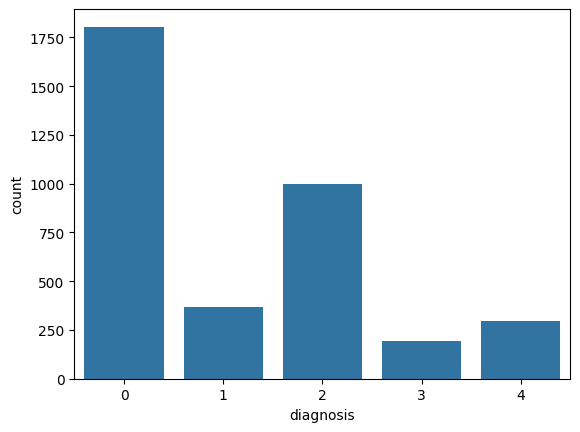

In [22]:
sns.countplot(combined_data,x='diagnosis')

In [23]:
image_dirs = [train_images,test_images,valid_images]
target_dir = "combined_images"
os.makedirs(target_dir, exist_ok=True)

for folder in image_dirs:
    for fname in os.listdir(folder):
        src = os.path.join(folder, fname)
        dst = os.path.join(target_dir, fname)
        if not os.path.exists(dst):
            shutil.copy2(src, dst)

In [24]:
target_size=500

In [25]:
data_downsampled=[]
for name,group in combined_data.groupby('diagnosis'):
  current_size=len(group)
  if current_size>target_size:
    data_downsampled.append(group.sample(target_size,random_state=42))
  else:
    data_downsampled.append(group)

downsampled_df=pd.concat(data_downsampled).reset_index(drop=True)
downsampled_df.head()

,id_code,diagnosis
0,ef5155990874,0
1,24de56d433cd,0
2,81914ceb4e74,0
3,a1b28bcbce00,0
4,c365c598ad4e,0


In [26]:
downsampled_df['diagnosis'].value_counts()

,count
diagnosis,
0,500
2,500
1,370
4,295
3,193


In [27]:
train_APTOS_df,val_test_APTOS_df=train_test_split(downsampled_df,test_size=0.2,random_state=42,stratify=downsampled_df['diagnosis'])
val_APTOS_df,test_APTOS_df=train_test_split(val_test_APTOS_df,test_size=0.5,random_state=42,stratify=val_test_APTOS_df['diagnosis'])

In [28]:

path = kagglehub.dataset_download("mariaherrerot/ddrdataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ddrdataset


In [29]:
list_dir = os.listdir(path)
images_path=os.path.join(path,list_dir[1],list_dir[1])
labels_path=os.path.join(path,list_dir[0])
print(images_path)
print(labels_path)

/kaggle/input/ddrdataset/DR_grading/DR_grading
/kaggle/input/ddrdataset/DR_grading.csv


In [30]:
labels_df=pd.read_csv(labels_path)
labels_df.head()

,id_code,diagnosis
0,20170413102628830.jpg,0
1,20170413111955404.jpg,0
2,20170413112015395.jpg,0
3,20170413112017305.jpg,0
4,20170413112528859.jpg,0


<Axes: xlabel='diagnosis', ylabel='count'>

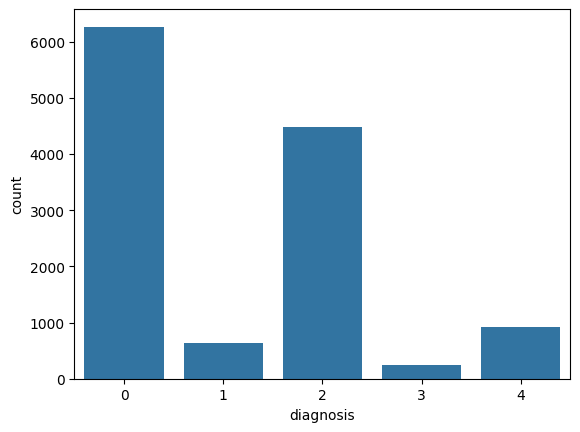

In [31]:
sns.countplot(x='diagnosis',data=labels_df)

In [32]:
labels_df['diagnosis'].value_counts()

,count
diagnosis,
0,6266
2,4477
4,913
1,630
3,236


In [33]:
size=800

In [34]:
new_data=[]
for name,group in labels_df.groupby('diagnosis'):
  targ_size=size-downsampled_df[downsampled_df['diagnosis']==name].shape[0]
  print(targ_size)
  if targ_size>0 :
    if targ_size>len(group):
      new_data.append(group)
    else:
      new_data.append(group.sample(targ_size,random_state=42))


300
430
300
607
505


In [35]:
collect_data=pd.concat(new_data).reset_index(drop=True)
collect_data.head()

,id_code,diagnosis
0,20170220085833145.jpg,0
1,20170329074906288.jpg,0
2,007-1981-100.jpg,0
3,007-0795-000.jpg,0
4,20170226223624346.jpg,0


In [36]:
for image in os.listdir(images_path):
  if image in collect_data['id_code'].values:
    src=os.path.join(images_path,image)
    dst=os.path.join(target_dir,image)
    if not os.path.exists(dst):
      shutil.copy2(src,dst)

<Axes: xlabel='diagnosis', ylabel='count'>

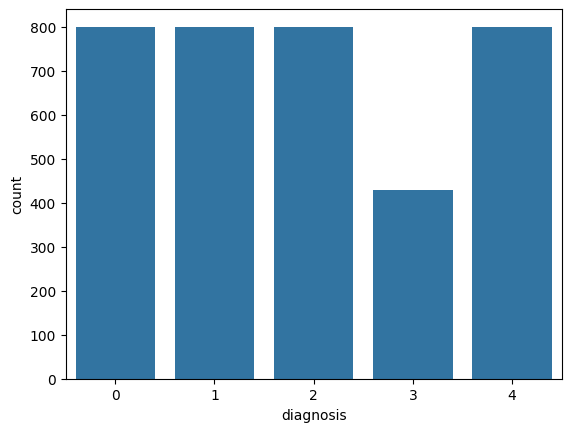

In [37]:
# prompt: histogram if the classes from the combined data

combined_full_data=pd.concat([downsampled_df,collect_data]).reset_index(drop=True)
combined_full_data['diagnosis'].value_counts()
sns.countplot(combined_full_data,x='diagnosis')

In [38]:
train_DDR_df,val_test_DDR_df=train_test_split(collect_data,test_size=0.2,random_state=42,stratify=collect_data['diagnosis'])
val_DDR_df,test_DDR_df=train_test_split(val_test_DDR_df,test_size=0.5,random_state=42,stratify=val_test_DDR_df['diagnosis'])

In [39]:
train_df=pd.concat([train_APTOS_df,train_DDR_df]).reset_index(drop=True)
val_df=pd.concat([val_APTOS_df,val_DDR_df]).reset_index(drop=True)
test_df=pd.concat([test_APTOS_df,test_DDR_df]).reset_index(drop=True)

In [40]:
train_df['diagnosis'].value_counts()

,count
diagnosis,
1,640
0,640
2,640
4,640
3,342


<Axes: xlabel='diagnosis', ylabel='count'>

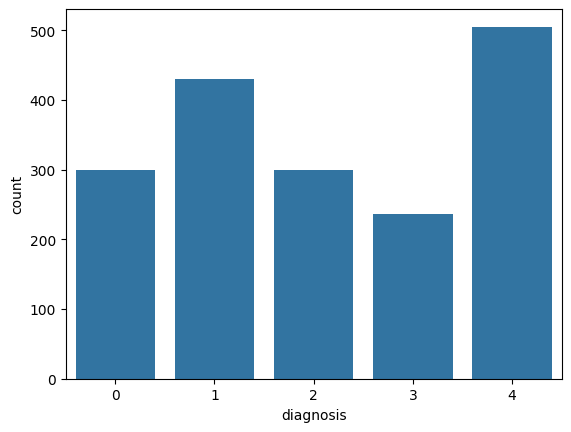

In [41]:
sns.countplot(x='diagnosis',data=collect_data)

<Axes: xlabel='diagnosis', ylabel='count'>

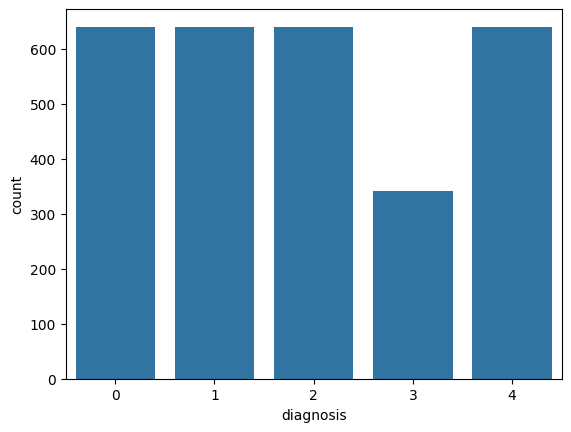

In [42]:
sns.countplot(x='diagnosis',data=train_df)

In [43]:
test_df['diagnosis'].value_counts()

,count
diagnosis,
0,80
1,80
2,80
4,80
3,44


In [44]:
val_df['diagnosis'].value_counts()

,count
diagnosis,
0,80
1,80
2,80
4,80
3,43


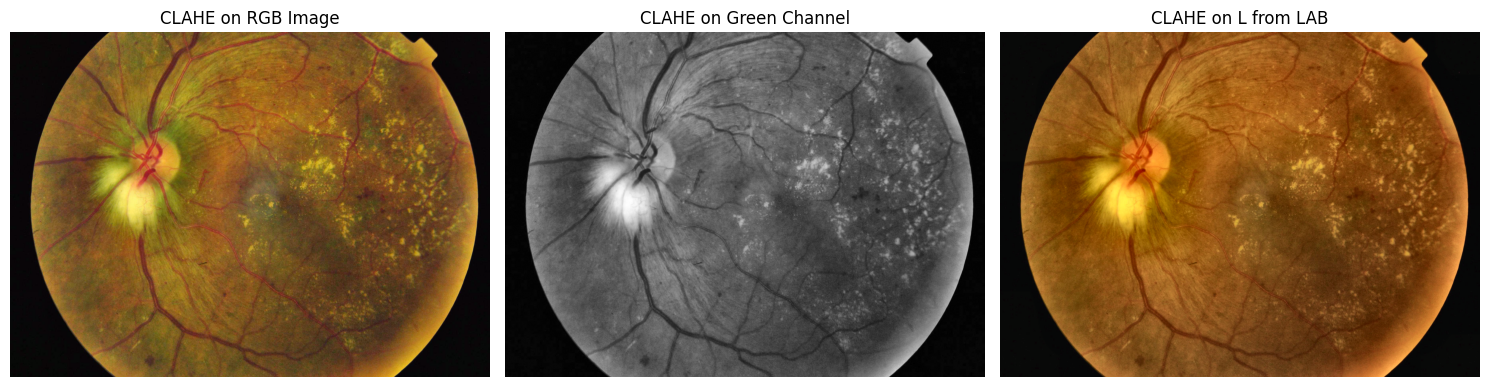

In [46]:
# Apply CLAHE on the original RGB image
clahe_rgb = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_applied_rgb = np.zeros_like(original_image)
for i in range(3): # Apply CLAHE to each channel
    clahe_applied_rgb[:,:,i] = clahe_rgb.apply(original_image[:,:,i])


# Apply CLAHE on the green channel
clahe_green = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_applied_green = clahe_green.apply(green_channel)

# Convert the original image to LAB color space
lab_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2LAB)

# Split the LAB image into L, A, and B channels
l_channel, a_channel, b_channel = cv2.split(lab_image)

# Apply CLAHE on the L channel
clahe_l = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_applied_l = clahe_l.apply(l_channel)

# Merge the CLAHE-applied L channel with the original A and B channels
clahe_applied_lab = cv2.merge((clahe_applied_l, a_channel, b_channel))

# Convert the CLAHE-applied LAB image back to RGB
clahe_applied_lab_rgb = cv2.cvtColor(clahe_applied_lab, cv2.COLOR_LAB2RGB)


# Visualize the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot CLAHE applied on RGB
axes[0].imshow(clahe_applied_rgb)
axes[0].set_title('CLAHE on RGB Image')
axes[0].axis('off')

# Plot CLAHE applied on Green Channel
axes[1].imshow(clahe_applied_green, cmap='gray')
axes[1].set_title('CLAHE on Green Channel')
axes[1].axis('off')

# Plot CLAHE applied on L from LAB
axes[2].imshow(clahe_applied_lab_rgb)
axes[2].set_title('CLAHE on L from LAB')
axes[2].axis('off')


plt.tight_layout()
plt.show()


In [48]:
class DRDatasetFromDF(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_id = row['id_code']
        label = row['diagnosis']

        #  First, try the image_id as is (in case it already has extension)
        image_path = os.path.join(self.images_dir, image_id)
        found = os.path.exists(image_path)

        # If not found, try adding extensions
        if not found:
            for ext in ['.png', '.jpg', '.jpeg']:
                image_path = os.path.join(self.images_dir, f"{image_id}{ext}")
                if os.path.exists(image_path):
                    found = True
                    break

        if not found:
            # List available files for debugging
            available_files = os.listdir(self.images_dir)[:10]  # Show first 10 files
            raise FileNotFoundError(f"Image not found: {image_id}\nChecked path: {self.images_dir}\nFirst 10 files in directory: {available_files}")

        # Load image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Green channel
        green = img[:, :, 1]

        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        green_clahe = clahe.apply(green)

        # Gaussian Blur
       # blurred = cv2.GaussianBlur(green_clahe, (5, 5), 0)

        # Convert to PIL
        img_pil = Image.fromarray(green_clahe)

        # Apply transform
        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            img_tensor = transforms.ToTensor()(img_pil)

        return img_tensor, label


In [50]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    #transforms.RandomErasing(p=0.3)
])

In [51]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),  # Less aggressive cropping
    # Remove RandomHorizontalFlip for medical images
    transforms.RandomRotation(degrees=15),  # Increase rotation range
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.05),  # Reduce color changes
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Add slight translation
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1))  # Enable with conservative settings
])

In [52]:
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [53]:
import numpy as np

class_counts = train_df['diagnosis'].value_counts().sort_index().values
print("Class counts:", class_counts)

# total samples = len(train_df)
num_samples = len(train_df)

Class counts: [640 640 640 342 640]


In [54]:
class_weights = 1. / class_counts
print("Class weights:", class_weights)

sample_weights = train_df['diagnosis'].apply(lambda x: class_weights[x]).values

Class weights: [0.0015625  0.0015625  0.0015625  0.00292398 0.0015625 ]


In [55]:
from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [56]:
train_dataset = DRDatasetFromDF(train_df, images_dir="combined_images", transform=train_transform)
val_dataset   = DRDatasetFromDF(val_df, images_dir="combined_images", transform=val_transform)
test_dataset  = DRDatasetFromDF(test_df, images_dir="combined_images", transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [57]:
!pip install efficientnet_pytorch


In [58]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from torch.optim import Adam
from tqdm import tqdm
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', in_channels=1, num_classes=5)
model._dropout = nn.Dropout(0.5)
original_fc = model._fc
model._fc = nn.Sequential(
    nn.Dropout(0.5),
    original_fc,
    nn.Dropout(0.3)
)
model.to(device)

# Define class weights (ordered by class index 0 → 4)
class_weights = torch.tensor([0.7, 1.0, 1.0, 1.8, 1.0], dtype=torch.float).to(device)

Loaded pretrained weights for efficientnet-b0


In [ ]:
from torch.optim import Adam
class_weights = torch.tensor([0.7, 1.0, 1.0, 1.8, 1.0], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import torch.nn as nn
import torch

# Define class weights (ordered by class index 0 → 4)
class_weights = torch.tensor([0.5, 1.3, 1.8, 2.0, 1.2], dtype=torch.float).to(device)

# Pass weights to CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)


# Optimizer with scheduler
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler - reduces LR by factor of 0.1 when validation loss plateaus
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)


In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
for param_group in optimizer.param_groups:
    param_group['lr'] = 1e-4


In [ ]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam
import copy
from tqdm import tqdm


# Checkpoint settings
checkpoint_path = 'checkpoint.pth'
best_model_path = 'best_model.pth'
start_epoch = 0
best_val_acc = 0.0
best_val_loss = float('inf')

# Load checkpoint if exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_acc = checkpoint['best_val_acc']
    print(f"✅ Loaded checkpoint from epoch {start_epoch}")

    for param_group in optimizer.param_groups:
        param_group['lr'] = 1e-4

# Training loop
num_epochs = 120
patience = 7
patience_counter = 0

for epoch in range(start_epoch, num_epochs):
    print(f"\n📘 Epoch {epoch+1}/{num_epochs}")

    # === Training ===
    model.train()
    train_loss, train_correct = 0.0, 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = train_correct / len(train_loader.dataset)
    avg_train_loss = train_loss / len(train_loader.dataset)

    # === Validation ===
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    avg_val_loss = val_loss / len(val_loader.dataset)

    scheduler.step(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {avg_val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")

    # === Early stopping ===
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹️ Early stopping!")
            break

    # === Save best model ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, best_model_path)
        print("✅ Saved best model.")

    # === Save checkpoint ===
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_acc': best_val_acc
    }, checkpoint_path)
    print("💾 Checkpoint saved.")


In [64]:
model.load_state_dict(torch.load('/content/best_model (4) (1).pth'))

<All keys matched successfully>

In [59]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [65]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


🔍 Classification Report:
              precision    recall  f1-score   support

           0     0.7419    0.8625    0.7977        80
           1     0.6714    0.5875    0.6267        80
           2     0.4938    0.5000    0.4969        80
           3     0.5152    0.3864    0.4416        44
           4     0.6897    0.7500    0.7186        80

    accuracy                         0.6401       364
   macro avg     0.6224    0.6173    0.6163       364
weighted avg     0.6330    0.6401    0.6336       364



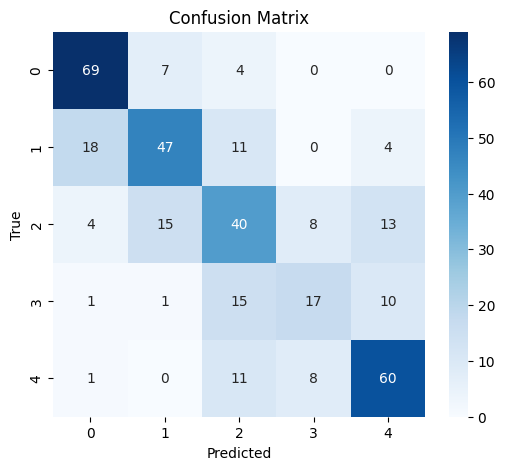

In [66]:
# Classification Report
print("🔍 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
